In [ ]:
# With pip:
!pip install facenet-pytorch

# or clone this repo, removing the '-' to allow python imports:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch


In [2]:
import os
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/facenet/dataset_faces/'

## MTCNN

In [5]:
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=228, device='cuda')

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [6]:
img = Image.open(data_dir+'/rodri/1.jpg')

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img)

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))


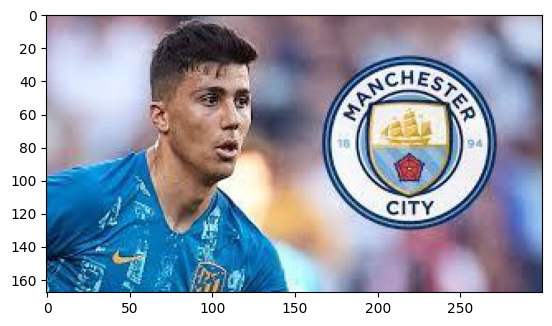

In [7]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [12]:
img_embedding.size()

torch.Size([1, 512])

In [13]:
img_cropped.size()

torch.Size([3, 228, 228])

### Cropped image

In [14]:
def faceAndEmbedding(img_path):
    img = Image.open(img_path)

    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(img)
    img_new = img_cropped.numpy()
    img_new = np.stack((img_new[0], img_new[1], img_new[2]), axis=2)
    # Calculate embedding (unsqueeze to add batch dimension)
    img_embedding = resnet(img_cropped.unsqueeze(0)).detach().numpy()
    return img_new, img_embedding

In [62]:
def get_embedding(img_path: str) -> np.ndarray:
    img = Image.open(img_path)
    img_cropped = mtcnn(img)
    img_embedding = resnet(img_cropped.unsqueeze(0)).detach().numpy()
    return img_embedding[0]

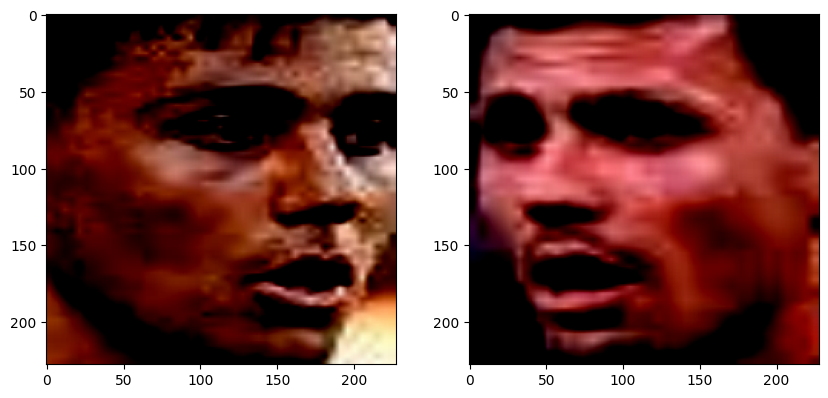

In [53]:
rodri1, rodri1_emb = faceAndEmbedding(data_dir+'rodri/1.jpg')
rodri2, rodri2_emb = faceAndEmbedding(data_dir+'rodri/4.jpg')

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rodri1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(rodri2)
plt.show()

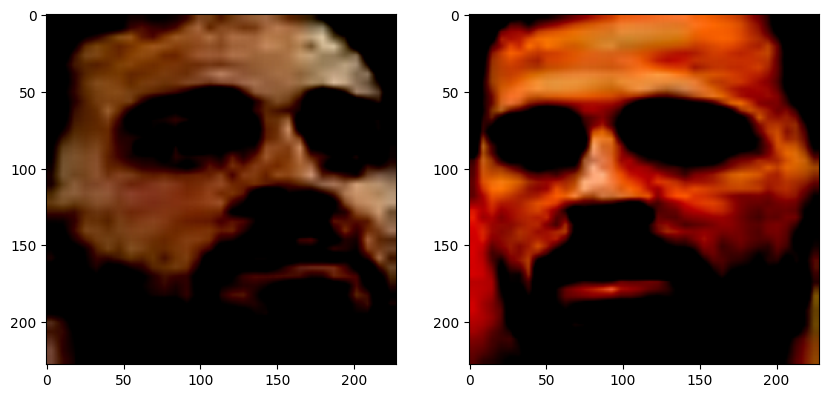

In [54]:
bernardo1, bernardo1_emb = faceAndEmbedding(data_dir+'bernardo/1.jpg')
bernardo2, bernardo2_emb = faceAndEmbedding(data_dir+'bernardo/4.jpg')

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(bernardo1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(bernardo2)
plt.show()

### Calculate Cosine Distance

In [55]:
from scipy.spatial import distance

In [56]:
distance.cosine(rodri1_emb[0], rodri1_emb[0])

0.0

In [57]:
distance.cosine(rodri1_emb[0], rodri2_emb[0])

0.3131787180900574

In [58]:
distance.cosine(rodri1_emb[0], bernardo1_emb[0])

0.6122672922770549

In [59]:
distance.cosine(rodri1_emb[0], bernardo2_emb[0])

0.8509263545274734

In [60]:
distance.cosine(rodri2_emb[0], bernardo1_emb[0])

0.7915838534583954

In [61]:
distance.cosine(rodri2_emb[0], bernardo2_emb[0])

0.9190971106290817

## Custom Dataset

In [45]:
for baller in os.listdir(data_dir):
    print('Baller:', baller)
    image_list = sorted(os.listdir(data_dir+baller))
    print(image_list)

Baller: rodri
['1.jpg', '10.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
Baller: bernardo
['1.jpg', '10.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
Baller: kdb
['1.jpg', '10.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


In [71]:
def merge_classes(ballers: list[str], data_dir: str) -> dict:
    data = {}

    for baller in ballers:
        baller_path = os.path.join(data_dir, baller)
        image_list = os.listdir(baller_path)

        if baller not in data:
            data[baller] = []

        data[baller].extend([get_embedding(os.path.join(baller_path, img)) for img in image_list])

    return data

In [72]:
data = merge_classes(ballers=['rodri', 'bernardo', 'kdb'], data_dir=data_dir)

In [80]:
data.keys()

dict_keys(['rodri', 'bernardo', 'kdb'])

In [130]:
new_data = []
for baller in data.keys():
    new_data.extend(data[baller])
new_data = np.array(new_data)
new_data.shape

(30, 512)

## Agglomerative Clustering

In [191]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [181]:
agg_cluster = AgglomerativeClustering(n_clusters=3)
clusters = agg_cluster.fit_predict(new_data)

In [177]:
clusters

array([0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [186]:
ground_truth = [2]*10
ground_truth.extend([1]*10)
ground_truth.extend([0]*10)

## Evaluate

In [187]:
def accuracy(clusters: np.ndarray, n_clusters: int=3) -> float:
    n_samples = len(clusters)/n_clusters
    total = 0
    for i in range(1, n_clusters+1):
        if i == 1:
            total+=sum([1 if label == 2 else 0 for label in clusters[:10]])
        elif i == 2:
            total+=sum([1 if label == 1 else 0 for label in clusters[10:20]])
        else:
            total+=sum([1 if label == 0 else 0 for label in clusters[20:]])
    return total/30

In [188]:
print('Accuracy: ', accuracy(clusters))

Accuracy:  0.9


In [190]:
cm = confusion_matrix(ground_truth, clusters)

In [192]:
class_names = ['rodri', 'bernardo', 'kdb']

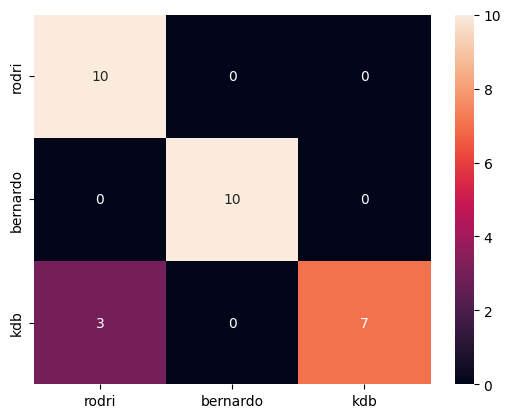

In [193]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.show()

## Visualize

In [194]:
from sklearn.decomposition import PCA

In [195]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(new_data)

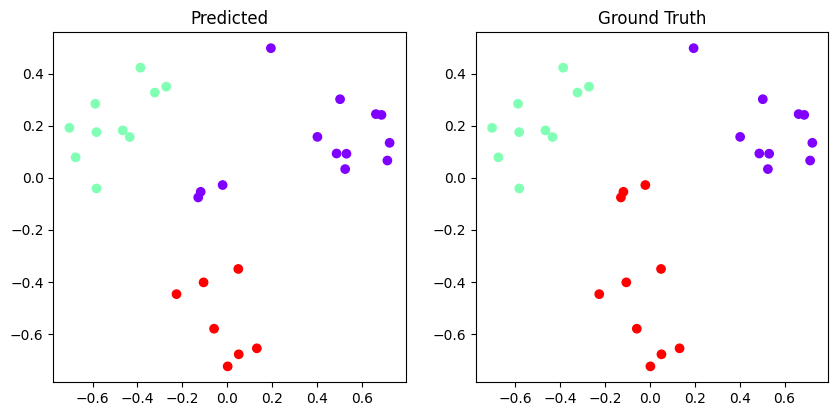

In [216]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(X_pca[:,0], X_pca[:,1], c = clusters, cmap ='rainbow')
ax1.title.set_text('Predicted')
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = ground_truth, cmap ='rainbow')
ax2.title.set_text('Ground Truth')
plt.show()